In [1]:
#!/usr/bin/env python
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import snntorch as snn
import matplotlib.pyplot as plt
import optuna
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from torch.utils.tensorboard import SummaryWriter
import plotly.graph_objects as go

# =============================================================================
# 1. Fix Random Seeds for Reproducibility
# =============================================================================
np.random.seed(42)
torch.manual_seed(42)

# =============================================================================
# 2. Helper Function to Create a Unique Output Folder
# =============================================================================
def create_unique_folder(base_dir):
    """
    Creates a unique folder inside base_dir with the naming pattern:
      trial_N_date_yyyy_mm_dd_hh_mm,
    where N is the highest number found among folders starting with "trial_"
    plus one.
    """
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    # List folders in base_dir that start with "trial_"
    existing = [d for d in os.listdir(base_dir)
                if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("trial_")]
    trial_numbers = []
    for folder in existing:
        match = re.match(r"trial_(\d+)_date_", folder)
        if match:
            trial_numbers.append(int(match.group(1)))
    next_trial = max(trial_numbers) + 1 if trial_numbers else 1
    now_str = datetime.now().strftime("%Y_%m_%d_%H_%M")
    folder_name = f"trial_{next_trial}_date_{now_str}"
    unique_folder = os.path.join(base_dir, folder_name)
    os.makedirs(unique_folder, exist_ok=True)
    return unique_folder

# =============================================================================
# 3. Load TSV Input and Plot It
# =============================================================================
def load_tsv_input(tsv_path, sample_index=0, output_folder="."):
    """
    Loads a TSV file with the following format:
      - The first column is the label (-1 for abnormal, 1 for normal)
      - The remaining columns are numeric features (each sample is a time series)
    
    It reads the file using pandas, converts the labels (if needed), and extracts
    the time series from the specified sample_index.
    
    The function also saves a high-quality PNG plot (dpi=300) of the input time series
    into the output_folder.
    
    Returns:
        A tensor of shape (1, time_steps, 1) representing the input.
    """
    data = pd.read_csv(tsv_path, sep='\t', header=0)
    raw_labels = data.iloc[:, 0].values.astype(int)
    labels = ((raw_labels == 1).astype(int))
    features = data.iloc[:, 1:].values.astype(np.float32)
    # Get one sample (time series) from the dataset.
    x_sample = features[sample_index]  # shape: (time_steps,)
    
    # Plot the input time series.
    plt.figure(figsize=(8, 4))
    plt.plot(x_sample, marker='o', linestyle='-')
    plt.title('TSV Input Time Series')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    input_png_path = os.path.join(output_folder, 'tsv_input.png')
    plt.savefig(input_png_path, dpi=300)
    plt.close()
    
    # Create tensor with shape (1, time_steps, 1)
    x_tensor = torch.tensor(x_sample, dtype=torch.float32).unsqueeze(1).unsqueeze(0)
    return x_tensor

# =============================================================================
# 4. Define the Spiking Reservoir Experiment Model
# =============================================================================
class SpikingReservoirExp(nn.Module):
    def __init__(self, threshold, beta_reservoir, reservoir_size=10, device='cpu'):
        """
        Args:
            threshold (float): Threshold for reservoir LIF neurons.
            beta_reservoir (float): β value for reservoir LIF neurons.
            reservoir_size (int): Number of reservoir neurons (default: 10).
            device (str): 'cpu' or 'cuda'
        """
        super(SpikingReservoirExp, self).__init__()
        self.device = device
        self.reservoir_size = reservoir_size
        
        # Input layer: one linear neuron mapping 1 input to 1.
        self.input_fc = nn.Linear(1, 1, bias=False)
        # Input LIF neuron (fixed parameters; not tuned here).
        self.input_lif = snn.Leaky(beta=0.99,
                                   threshold=threshold,
                                   spike_grad=None,
                                   reset_mechanism='zero',
                                   reset_delay=0)
        
        # Reservoir: a linear mapping from 1 to reservoir_size.
        self.reservoir_fc = nn.Linear(1, reservoir_size, bias=False)
        # Reservoir LIF layer with hyperparameters to be tuned.
        self.reservoir_lif = snn.RLeaky(beta=beta_reservoir,
                                        linear_features=reservoir_size,
                                        threshold=threshold,
                                        spike_grad=None,
                                        reset_mechanism='zero',
                                        reset_delay=0,
                                        all_to_all=True)
        
        # Initialize the recurrent weight matrix:
        # Uniform initialization in [-1, 1] then scaling to a desired spectral radius.
        with torch.no_grad():
            nn.init.uniform_(self.reservoir_lif.recurrent.weight, a=0.01, b=2.0)
            W = self.reservoir_lif.recurrent.weight
            eigenvalues = torch.linalg.eigvals(W)
            current_radius = eigenvalues.abs().max()
            desired_radius = 0.5
            scaling_factor = desired_radius / current_radius
            W.mul_(scaling_factor)
        
        self.to(self.device)
    
    def forward(self, x):
        """
        Simulate the reservoir dynamics one time step at a time.
        
        Args:
            x (tensor): Input tensor of shape (batch_size, time_steps, 1).
            
        Returns:
            avg_firing_rate (float): Average firing rate (over neurons and time).
            spike_record (np.array): Reservoir spike record with shape 
                                     (time_steps, batch_size, reservoir_size).
            mem_record (np.array): Reservoir membrane potential record (same shape).
        """
        batch_size, time_steps, _ = x.shape
        x = x.to(self.device)
        
        # Initialize states.
        input_mem = torch.zeros(batch_size, 1, device=self.device)
        reservoir_mem = torch.zeros(batch_size, self.reservoir_size, device=self.device)
        reservoir_spk = torch.zeros(batch_size, self.reservoir_size, device=self.device)
        
        spike_record = []
        mem_record = []
        
        for t in range(time_steps):
            x_t = x[:, t, :]  # shape: (batch_size, 1)
            input_current = self.input_fc(x_t)
            input_spk, input_mem = self.input_lif(input_current, input_mem)
            reservoir_current = self.reservoir_fc(input_spk)
            reservoir_spk, reservoir_mem = self.reservoir_lif(reservoir_current,
                                                              reservoir_spk,
                                                              reservoir_mem)
            spike_record.append(reservoir_spk.detach().cpu().numpy())
            mem_record.append(reservoir_mem.detach().cpu().numpy())
        
        spike_record = np.array(spike_record)  # shape: (time_steps, batch_size, reservoir_size)
        mem_record = np.array(mem_record)
        avg_firing_rate = spike_record.mean()
        
        return avg_firing_rate, spike_record, mem_record
    
    def get_recurrent_weights(self):
        """Return the recurrent weight matrix as a numpy array."""
        return self.reservoir_lif.recurrent.weight.detach().cpu().numpy()

# =============================================================================
# 5. Define the Optuna Objective Function (Using a Grid Search)
# =============================================================================
def objective(trial):
    # Hyperparameters to tune.
    threshold = trial.suggest_float("threshold", 0.3, 3.0)
    beta_reservoir = trial.suggest_float("beta_reservoir", 0.4, 0.8)
    
    device = 'cpu'
    model = SpikingReservoirExp(threshold, beta_reservoir, reservoir_size=100, device=device)
    model.eval()
    
    # Get TSV file path from trial.user_attrs.
    tsv_file = trial.user_attrs.get("tsv_file")
    if tsv_file is None:
        raise ValueError("TSV file path must be provided in trial.user_attrs")
    
    # Use the unique output folder provided via trial.user_attrs.
    output_folder = trial.user_attrs.get("output_folder", ".")
    
    # Load TSV input (a single sample) as the input time series.
    x = load_tsv_input(tsv_file, sample_index=0, output_folder=output_folder)
    
    avg_firing_rate, spike_record, mem_record = model(x)
    
    # Save extra info in trial attributes for later detailed plotting.
    trial.set_user_attr("spike_record", spike_record)
    trial.set_user_attr("mem_record", mem_record)
    trial.set_user_attr("weights", model.get_recurrent_weights())
    
    return avg_firing_rate

# =============================================================================
# 6. Main Function: Run Grid Search, Save Plots, Hyperparameters, and Log to TensorBoard
# =============================================================================
if __name__ == '__main__':
    # Base directory for results.
    base_output_dir = "results"
    output_folder = create_unique_folder(base_output_dir)
    print(f"Output folder: {output_folder}")
    
    # Initialize TensorBoard writer with the unique output folder.
    writer = SummaryWriter(log_dir=output_folder)
    
    # Define the TSV file path (update this to your actual TSV file).
    tsv_file = "/Users/mikel/Documents/GitHub/polimikel/data/UCR_dataset/Wafer/Wafer_TRAIN.tsv"
    
    # Define grid search values (10 discrete values each → 100 trials).
    threshold_values = np.linspace(0.1, 2.0, 30).tolist()
    beta_values = np.linspace(0.1, 0.99, 30).tolist()
    search_space = {"threshold": threshold_values, "beta_reservoir": beta_values}
    
    # Use Optuna's GridSampler.
    sampler = optuna.samplers.GridSampler(search_space)
    study = optuna.create_study(sampler=sampler, direction="maximize")
    
    # Pass the output folder and TSV file path to each trial via user_attrs.
    def objective_with_folder(trial):
        trial.set_user_attr("output_folder", output_folder)
        trial.set_user_attr("tsv_file", tsv_file)
        return objective(trial)
    
    study.optimize(objective_with_folder, n_trials=len(threshold_values) * len(beta_values))
    
    # -----------------------------------------------------------------------------
    # (A) Extract Results for 3D Surface Plot and Heatmap
    # -----------------------------------------------------------------------------
    trials = study.trials
    firing_rate_grid = np.zeros((len(threshold_values), len(beta_values)))
    for trial in trials:
        t_val = trial.params["threshold"]
        b_val = trial.params["beta_reservoir"]
        i = threshold_values.index(t_val)
        j = beta_values.index(b_val)
        firing_rate_grid[i, j] = trial.value
    
    # 1. 3D Surface Plot (Static)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(beta_values, threshold_values)
    surf = ax.plot_surface(X, Y, firing_rate_grid, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Beta Reservoir')
    ax.set_ylabel('Threshold')
    ax.set_zlabel('Avg Firing Rate')
    ax.set_title('3D Surface Plot of Avg Firing Rate')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    surface_path = os.path.join(output_folder, '3d_surface_plot.png')
    plt.savefig(surface_path, dpi=300)
    writer.add_figure("3D_Surface_Plot", fig)
    plt.close()
    
    # 2. Heatmap of the Average Firing Rate (Static)
    plt.figure(figsize=(8, 6))
    plt.imshow(firing_rate_grid, origin='lower', aspect='auto',
               extent=[min(beta_values), max(beta_values), min(threshold_values), max(threshold_values)],
               cmap='viridis')
    plt.colorbar(label='Avg Firing Rate')
    plt.xlabel('Beta Reservoir')
    plt.ylabel('Threshold')
    plt.title('Heatmap of Avg Firing Rate')
    plt.tight_layout()
    heatmap_path = os.path.join(output_folder, 'heatmap_firing_rate.png')
    plt.savefig(heatmap_path, dpi=300)
    writer.add_figure("Heatmap_Firing_Rate", plt.gcf())
    plt.close()
    
    # -----------------------------------------------------------------------------
    # (B) Choose a Representative Trial for Detailed Plots
    # -----------------------------------------------------------------------------
    rep_threshold = threshold_values[len(threshold_values)//2]
    rep_beta = beta_values[len(beta_values)//2]
    rep_trial = None
    for trial in trials:
        if trial.params["threshold"] == rep_threshold and trial.params["beta_reservoir"] == rep_beta:
            rep_trial = trial
            break
    if rep_trial is None:
        rep_trial = trials[0]
    
    # Save hyperparameters of the representative trial.
    hyperparams_file = os.path.join(output_folder, "hyperparameters.txt")
    with open(hyperparams_file, "w") as f:
        f.write("Representative Trial Hyperparameters:\n")
        for key, value in rep_trial.params.items():
            f.write(f"{key}: {value}\n")
    
    spike_record = rep_trial.user_attrs["spike_record"]  # (time_steps, 1, reservoir_size)
    mem_record = rep_trial.user_attrs["mem_record"]
    weights = rep_trial.user_attrs["weights"]
    
    # Remove batch dimension.
    spike_record = spike_record[:, 0, :]  # (time_steps, reservoir_size)
    mem_record = mem_record[:, 0, :]
    time_steps = spike_record.shape[0]
    
    # 1. Spike Raster Plot (Static)
    plt.figure(figsize=(10, 6))
    for neuron in range(spike_record.shape[1]):
        spike_times = np.where(spike_record[:, neuron] > 0)[0]
        plt.scatter(spike_times, np.full_like(spike_times, neuron), s=10)
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.title('Spike Raster Plot')
    plt.yticks(range(spike_record.shape[1]))
    plt.grid(True)
    plt.tight_layout()
    spike_raster_path = os.path.join(output_folder, 'spike_raster_plot.png')
    plt.savefig(spike_raster_path, dpi=300)
    writer.add_figure("Spike_Raster_Plot", plt.gcf())
    plt.close()
    
    # 2. Membrane Potential Traces (Static)
    plt.figure(figsize=(10, 6))
    for neuron in range(mem_record.shape[1]):
        plt.plot(mem_record[:, neuron], label=f'Neuron {neuron}')
    plt.xlabel('Time Step')
    plt.ylabel('Membrane Potential')
    plt.title('Membrane Potential Traces')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    mem_trace_path = os.path.join(output_folder, 'membrane_potential_traces.png')
    plt.savefig(mem_trace_path, dpi=300)
    writer.add_figure("Membrane_Potential_Traces", plt.gcf())
    plt.close()
    
    # 3. Inter-Spike Interval (ISI) Histogram (Static)
    all_intervals = []
    for neuron in range(spike_record.shape[1]):
        spike_times = np.where(spike_record[:, neuron] > 0)[0]
        if len(spike_times) > 1:
            intervals = np.diff(spike_times)
            all_intervals.extend(intervals)
    plt.figure(figsize=(8, 6))
    plt.hist(all_intervals, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Inter-Spike Interval (Time Steps)')
    plt.ylabel('Count')
    plt.title('Inter-Spike Interval Histogram')
    plt.grid(True)
    plt.tight_layout()
    isi_path = os.path.join(output_folder, 'isi_histogram.png')
    plt.savefig(isi_path, dpi=300)
    writer.add_figure("ISI_Histogram", plt.gcf())
    plt.close()
    
    # 4. Recurrent Weight Matrix Heatmap (Static)
    plt.figure(figsize=(6, 5))
    plt.imshow(weights, cmap='bwr', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.xlabel('Post-synaptic Neuron')
    plt.ylabel('Pre-synaptic Neuron')
    plt.title('Recurrent Weight Matrix Heatmap')
    plt.tight_layout()
    weight_heatmap_path = os.path.join(output_folder, 'weight_matrix_heatmap.png')
    plt.savefig(weight_heatmap_path, dpi=300)
    writer.add_figure("Weight_Matrix_Heatmap", plt.gcf())
    plt.close()
    
    # 5. Eigenvalues of the Recurrent Weight Matrix (Static)
    eigenvalues = np.linalg.eigvals(weights)
    plt.figure(figsize=(8, 6))
    plt.scatter(eigenvalues.real, eigenvalues.imag, c='purple', edgecolors='k')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Eigenvalues of the Recurrent Weight Matrix')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.tight_layout()
    eigen_path = os.path.join(output_folder, 'eigenvalues.png')
    plt.savefig(eigen_path, dpi=300)
    writer.add_figure("Eigenvalues", plt.gcf())
    plt.close()
    
    # Log weight histogram and representative average firing rate.
    writer.add_histogram("Recurrent_Weights", weights, global_step=0)
    writer.add_scalar("Representative_Avg_Firing_Rate", rep_trial.value, global_step=0)
    writer.add_hparams(rep_trial.params, {"hparam/avg_firing_rate": rep_trial.value})
    writer.close()
    
    # -----------------------------------------------------------------------------
    # (C) Create Interactive Versions with Plotly
    # -----------------------------------------------------------------------------
    # TSV Input Interactive Plot
    # (Load the TSV file and plot the first sample's time series.)
    data = pd.read_csv(tsv_file, sep='\t', header=0)
    x_sample = data.iloc[0, 1:].values.astype(np.float32)
    num_steps = len(x_sample)
    fig_input = go.Figure(data=go.Scatter(x=np.arange(num_steps), y=x_sample, mode='lines+markers'))
    fig_input.update_layout(title='TSV Input Time Series',
                            xaxis_title='Time Step',
                            yaxis_title='Value')
    fig_input.write_html(os.path.join(output_folder, 'tsv_input_interactive.html'))
    
    # 3D Surface Plot Interactive
    fig_3d = go.Figure(data=[go.Surface(z=firing_rate_grid, x=beta_values, y=threshold_values,
                                         colorscale='Viridis')])
    fig_3d.update_layout(title='3D Surface Plot of Avg Firing Rate',
                         scene=dict(xaxis_title='Beta Reservoir',
                                    yaxis_title='Threshold',
                                    zaxis_title='Avg Firing Rate'))
    fig_3d.write_html(os.path.join(output_folder, '3d_surface_plot_interactive.html'))
    
    # Heatmap Interactive
    fig_heatmap = go.Figure(data=go.Heatmap(z=firing_rate_grid, x=beta_values, y=threshold_values,
                                            colorscale='Viridis'))
    fig_heatmap.update_layout(title='Heatmap of Avg Firing Rate',
                              xaxis_title='Beta Reservoir',
                              yaxis_title='Threshold')
    fig_heatmap.write_html(os.path.join(output_folder, 'heatmap_firing_rate_interactive.html'))
    
    # Spike Raster Plot Interactive
    fig_raster = go.Figure()
    for neuron in range(spike_record.shape[1]):
        spike_times = np.where(spike_record[:, neuron] > 0)[0]
        fig_raster.add_trace(go.Scatter(x=spike_times,
                                        y=np.full_like(spike_times, neuron),
                                        mode='markers',
                                        name=f'Neuron {neuron}',
                                        marker=dict(size=6)))
    fig_raster.update_layout(title='Spike Raster Plot',
                             xaxis_title='Time Step',
                             yaxis_title='Neuron Index')
    fig_raster.write_html(os.path.join(output_folder, 'spike_raster_plot_interactive.html'))
    
    # Membrane Potential Traces Interactive
    time_axis = np.arange(time_steps)
    fig_mem = go.Figure()
    for neuron in range(mem_record.shape[1]):
        fig_mem.add_trace(go.Scatter(x=time_axis, y=mem_record[:, neuron],
                                     mode='lines',
                                     name=f'Neuron {neuron}'))
    fig_mem.update_layout(title='Membrane Potential Traces',
                          xaxis_title='Time Step',
                          yaxis_title='Membrane Potential')
    fig_mem.write_html(os.path.join(output_folder, 'membrane_potential_traces_interactive.html'))
    
    # ISI Histogram Interactive
    fig_isi = go.Figure(data=[go.Histogram(x=all_intervals, nbinsx=30,
                                           marker_color='skyblue')])
    fig_isi.update_layout(title='Inter-Spike Interval Histogram',
                          xaxis_title='Inter-Spike Interval (Time Steps)',
                          yaxis_title='Count')
    fig_isi.write_html(os.path.join(output_folder, 'isi_histogram_interactive.html'))
    
    # Weight Matrix Heatmap Interactive
    fig_weights = go.Figure(data=go.Heatmap(z=weights, colorscale='RdBu'))
    fig_weights.update_layout(title='Recurrent Weight Matrix Heatmap',
                              xaxis_title='Post-synaptic Neuron',
                              yaxis_title='Pre-synaptic Neuron')
    fig_weights.write_html(os.path.join(output_folder, 'weight_matrix_heatmap_interactive.html'))
    
    # Eigenvalues Interactive Plot
    fig_eigen = go.Figure(data=go.Scatter(x=eigenvalues.real,
                                          y=eigenvalues.imag,
                                          mode='markers',
                                          marker=dict(size=10, color='purple')))
    fig_eigen.update_layout(title='Eigenvalues of the Recurrent Weight Matrix',
                            xaxis_title='Real Part',
                            yaxis_title='Imaginary Part')
    fig_eigen.write_html(os.path.join(output_folder, 'eigenvalues_interactive.html'))
    
    print("All static and interactive plots, logs, and hyperparameters have been saved.")

[I 2025-02-13 09:33:22,832] A new study created in memory with name: no-name-8beffe26-3865-478d-b400-24a79cbc3a80


Output folder: results/trial_11_date_2025_02_13_09_33


[I 2025-02-13 09:33:23,050] Trial 0 finished with value: 0.01894736848771572 and parameters: {'threshold': 0.886206896551724, 'beta_reservoir': 0.5910344827586207}. Best is trial 0 with value: 0.01894736848771572.
/opt/anaconda3/envs/NeuroVecio/lib/python3.9/site-packages/optuna/samplers/_grid.py:199: UserWarning: The value `0.22275862068965518` is out of range of the parameter `beta_reservoir`. The value will be used but the actual distribution is: `FloatDistribution(high=0.8, log=False, low=0.4, step=None)`.
  warnings.warn(
[I 2025-02-13 09:33:23,249] Trial 1 finished with value: 0.0 and parameters: {'threshold': 1.475862068965517, 'beta_reservoir': 0.22275862068965518}. Best is trial 0 with value: 0.01894736848771572.
[I 2025-02-13 09:33:23,443] Trial 2 finished with value: 0.0 and parameters: {'threshold': 1.3448275862068966, 'beta_reservoir': 0.4989655172413794}. Best is trial 0 with value: 0.01894736848771572.
/opt/anaconda3/envs/NeuroVecio/lib/python3.9/site-packages/optuna/sam

All static and interactive plots, logs, and hyperparameters have been saved.


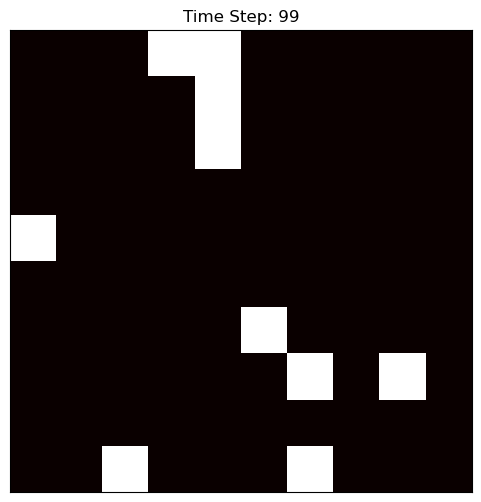

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create synthetic spike data:
# Let's say T=100 time steps and 100 neurons (binary spikes).
T = 100
num_neurons = 100
p_spike = 0.1  # probability that a given neuron spikes at a given time
# Generate a binary matrix (T, 100)
spike_data = (np.random.rand(T, num_neurons) < p_spike).astype(float)

# Set up the figure and axis.
fig, ax = plt.subplots(figsize=(6, 6))
# Initially display the first time step reshaped into a 10x10 grid.
im = ax.imshow(spike_data[0].reshape(10, 10), cmap='hot', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Time Step: 0")

def update_frame(t):
    # Reshape the spike vector at time t into a 10x10 grid.
    grid = spike_data[t].reshape(10, 10)
    im.set_data(grid)
    ax.set_title(f"Time Step: {t}")
    return [im]

# Create the animation; adjust interval (ms) for frame rate.
ani = animation.FuncAnimation(fig, update_frame, frames=T, interval=200, blit=True)

# To display the animation in an interactive window (or in a Jupyter cell), use:
#plt.show()

# Optionally, to save as a video:
ani.save("spike_raster_animation.mp4", fps=10, extra_args=['-vcodec', 'libx264'])


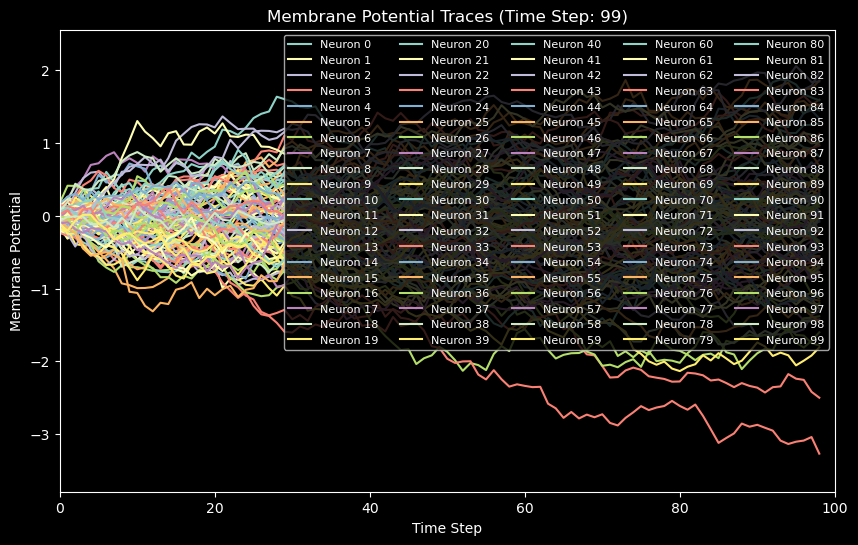

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Assume mem_record is an array of shape (T, N) for T time steps and N neurons.
T = 100  # number of time steps
N = 100  # reservoir neurons
# Generate synthetic membrane potential traces for illustration.
mem_record = np.cumsum(np.random.randn(T, N) * 0.1, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
lines = [ax.plot([], [], label=f'Neuron {i}')[0] for i in range(N)]
ax.set_xlim(0, T)
ax.set_ylim(np.min(mem_record)-0.5, np.max(mem_record)+0.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('Membrane Potential')
ax.set_title('Membrane Potential Traces')
ax.legend(loc='upper right', ncol=5, fontsize=8)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(t):
    x = np.arange(t)
    for i, line in enumerate(lines):
        line.set_data(x, mem_record[:t, i])
    ax.set_title(f'Membrane Potential Traces (Time Step: {t})')
    return lines

ani = animation.FuncAnimation(fig, update, frames=T, init_func=init, interval=100, blit=True)
#plt.show()
ani.save("membrane_traces.mp4", fps=10, extra_args=['-vcodec', 'libx264'])


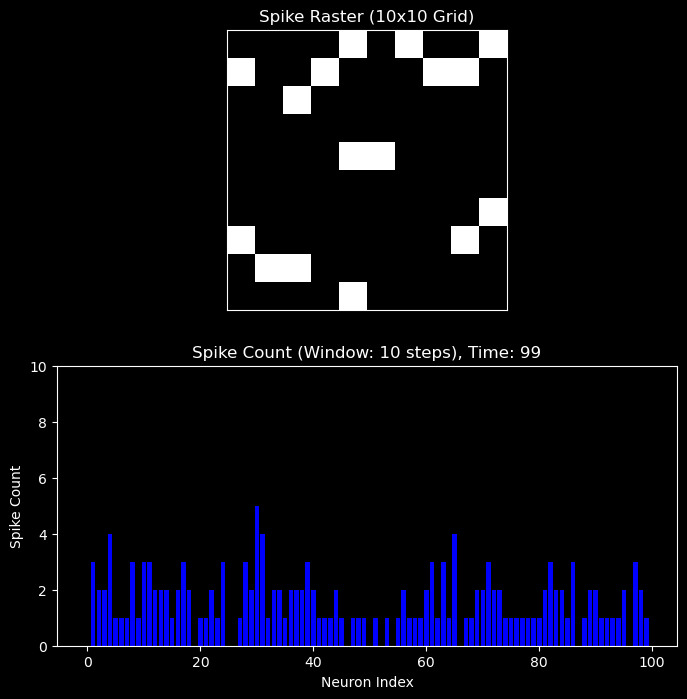

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

T = 100  # number of time steps
N = 100  # number of neurons

# Generate synthetic spike data (binary) for demonstration.
spike_data = (np.random.rand(T, N) < 0.15).astype(float)
# Compute spike counts over a sliding window (here, the last 10 time steps)
window = 10

fig, (ax_raster, ax_bar) = plt.subplots(2, 1, figsize=(8, 8))
raster_im = ax_raster.imshow(spike_data[0].reshape(10, 10), cmap='gray', vmin=0, vmax=1)
ax_raster.set_title("Spike Raster (10x10 Grid)")
ax_raster.set_xticks([])
ax_raster.set_yticks([])

bar_container = ax_bar.bar(range(N), np.zeros(N), color='blue')
ax_bar.set_ylim(0, window)
ax_bar.set_xlabel("Neuron Index")
ax_bar.set_ylabel("Spike Count")
ax_bar.set_title("Spike Count over Last 10 Time Steps")

def update(t):
    # Update raster (reshape spikes at time t into a 10x10 grid)
    raster_im.set_data(spike_data[t].reshape(10,10))
    # Compute spike count in the sliding window for each neuron.
    start = max(0, t-window+1)
    spike_counts = np.sum(spike_data[start:t+1, :], axis=0)
    for rect, h in zip(bar_container, spike_counts):
        rect.set_height(h)
    ax_bar.set_title(f"Spike Count (Window: {window} steps), Time: {t}")
    return [raster_im] + list(bar_container)

ani = animation.FuncAnimation(fig, update, frames=T, interval=200, blit=True)
#plt.show()
ani.save("spike_raster_and_count.mp4", fps=10, extra_args=['-vcodec', 'libx264'])
